# Visualize patches

In [16]:
# imports
import os, sys

# third party imports
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import os
from scipy import ndimage
from IPython import display 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nibabel as nib
from ants import from_numpy, resample_image, registration, apply_transforms
import pydicom

# Variables and paths

In [21]:
Moving_phase = 'D'
fixed_phase  = 'P'
patch_size = 64


train_D = "/media/monib/ext1/work2022/Base_Dataset/vm_data_affine_d2p/train/example_A/HCC_1246_d"



In [30]:

    
def read_dicom_files(dicom_dir):
    try:
        dicom_files = glob.glob(os.path.join(dicom_dir, "*.*"))
        sorted_dicom_files = sorted(dicom_files)
        stacked_dicom = [pydicom.dcmread(dicom_file) for dicom_file in sorted_dicom_files]
        return stacked_dicom
    except IndexError as e:
        print(f"{e}, at path {dicom_dir}")
        return None

def create_3d(dicom_files):
    stacked_dicom = dicom_files  # stack of dicom files in a list

    image_shape = list(stacked_dicom[0].pixel_array.shape)
    image_shape.append(len(stacked_dicom))
    image_3d = np.zeros(image_shape)

    for j in range(len(stacked_dicom)):
        image_3d[:, :, j] = stacked_dicom[j].pixel_array

    return image_3d

def make_patches(image,patch_size= 64):
    stride = int(patch_size)

    image_patches = []
    locations = []
    for i in range(0, image.shape[0], stride):
        for j in range(0, image.shape[1], stride):
            Patch = np.zeros((patch_size, patch_size, 192))
            Patch[Patch==0]= -1024/10000
            img_patch = image[i:i + patch_size, j:j + patch_size, :]

            Patch[:img_patch.shape[0], :img_patch.shape[1], :] = img_patch

            patch_img = Patch
            image_patches.append(patch_img)
            locations.append((i,j))

    patch_array = np.zeros((len(image_patches),patch_size,patch_size,image.shape[-1]))
    for idx in range(len(image_patches)):
        patch_array[idx,:,:,:] =image_patches[idx]
    return patch_array, locations

In [31]:
Train_num = 1
T_moving = np.zeros((Train_num,512,512,192))


In [45]:
image = create_3d(read_dicom_files(train_D))/10000

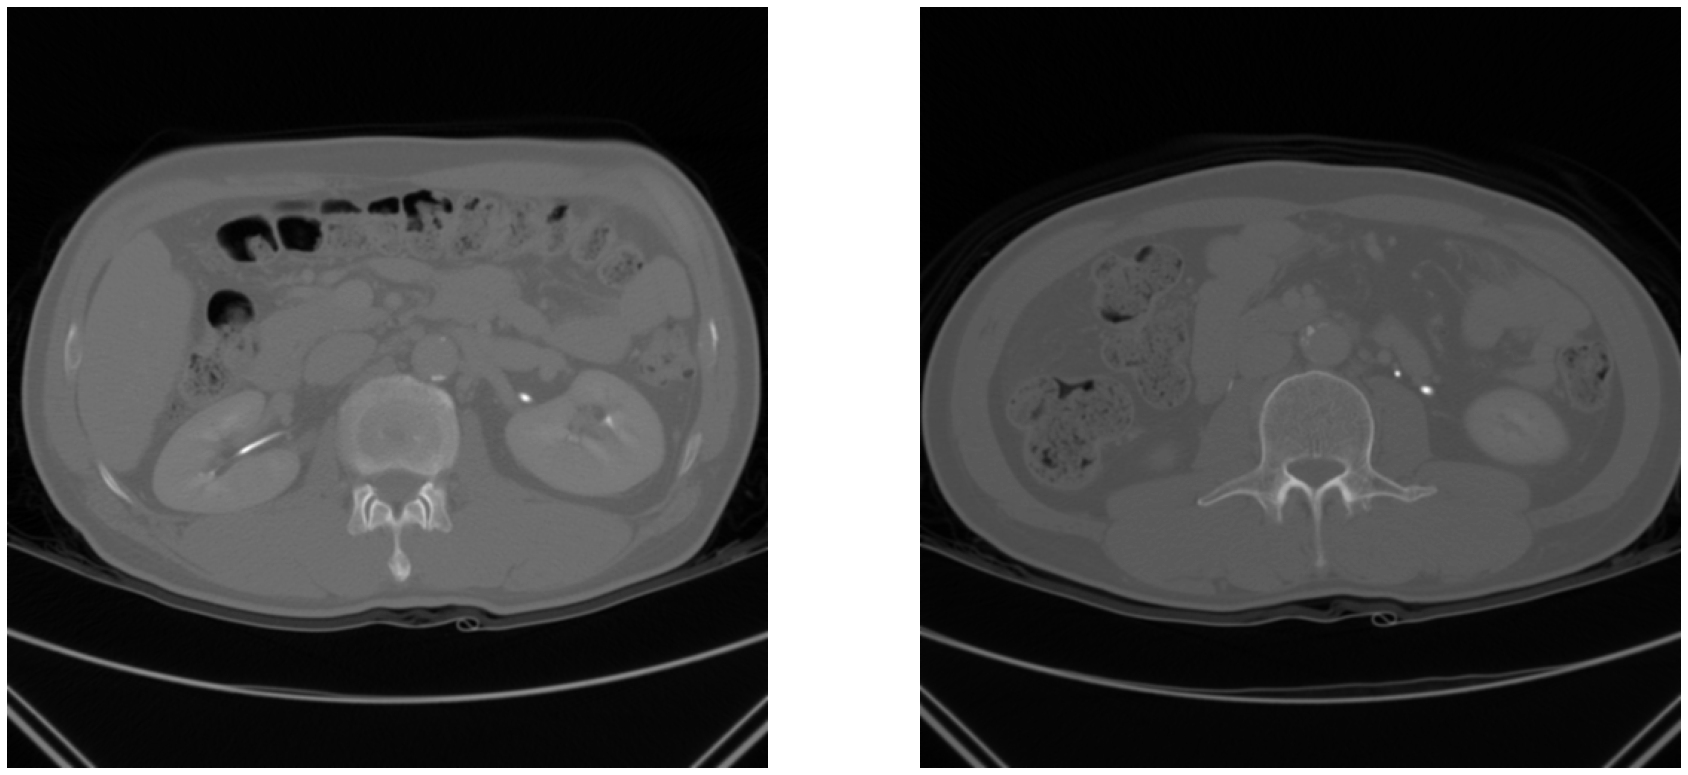

In [46]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2) =plt.subplots(1, 2,figsize=(30,30))


z1_plot = ax1.imshow(image[:, :, 40] ,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(image[:, :, 50] ,cmap='gray')
ax2.axis("off")

plt.show()

# Create patches

In [34]:

print(image.shape)
img_cp = np.zeros((512,512,192))
img_cp[...,:image.shape[-1]] = image

patch_array, locations = make_patches(img_cp)
print(len(patch_array))

(512, 512, 66)
64


In [37]:
patch_array[10].shape

(64, 64, 192)

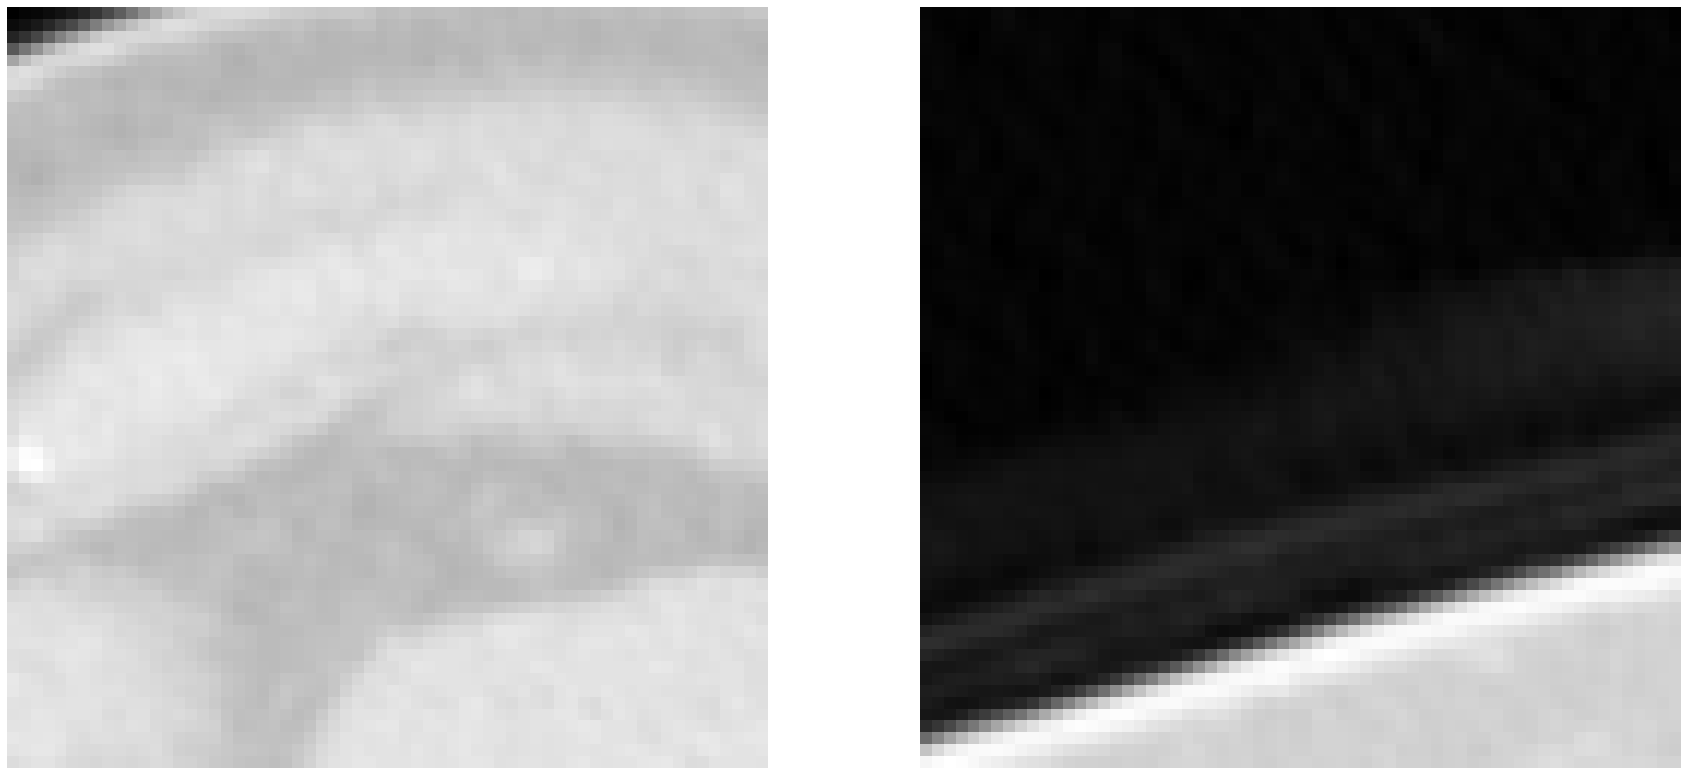

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2) =plt.subplots(1, 2,figsize=(30,30))


z1_plot = ax1.imshow(patch_array[10][:, :, 30] ,cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(patch_array[10][:, :, 50] ,cmap='gray')
ax2.axis("off")

plt.show()

In [43]:
recon_image = np.zeros((512,512,192))
for loc_idx in range(len(locations)):
    a_coor_A, b_coor_A = locations[loc_idx][0] , locations[loc_idx][1]  
    recon_image[a_coor_A:a_coor_A+patch_size,
                b_coor_A:b_coor_A+patch_size,...]= patch_array[loc_idx]
    

recon_image =recon_image[:512,:512,:]*10000

print(recon_image.shape)
print(recon_image.max())
print(recon_image.min())

(512, 512, 192)
3556.0000000000005
0.0


In [ ]:
slice_number = 170
predict = recon_image[:,:,slice_number]

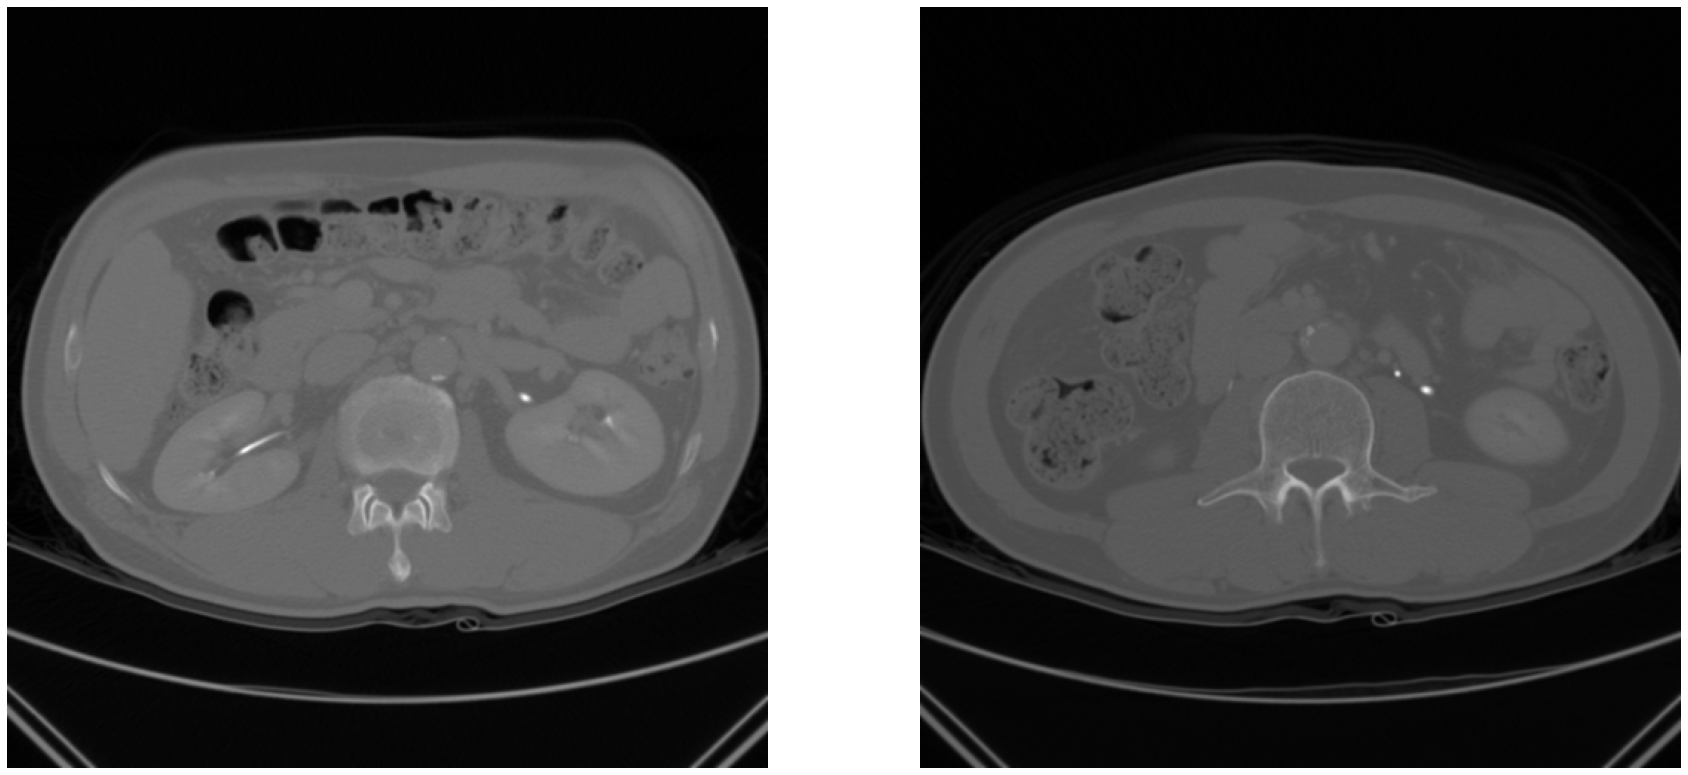

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig , (ax1,ax2) =plt.subplots(1, 2,figsize=(30,30))

z1_plot = ax1.imshow(recon_image[:, :, 40],cmap='gray')
ax1.axis("off")

z2_plot = ax2.imshow(recon_image[:, :, 50],cmap='gray')
ax2.axis("off")

plt.show()